# COMP 370 Homework 4 (311 Data Analysis)

### Task 0: Setup a git repo

1. If you haven't done so yet, set up your Github account by referring to the following quickstart tutorial:

https://docs.github.com/en/get-started/getting-started-with-git/set-up-git

2. Create a new GitHub repository: Go to GitHub, create a new repository (e.g., comp-370), and follow the prompts to create it.

3. Clone the repository locally:

Make sure to setup your SSH key here: https://github.com/settings/keys

### Task 1: CLI investigation tool

1. Use `grep` to filter incidents from 2020. In your terminal, run the following:

Explanation:
- `tar -xOzf nyc_311.csv.tgz`: This extracts the contents of the .tgz file and sends the output (-O) to the standard output (i.e., the terminal) without writing it to disk.
- `grep '2020'`: This filters the lines that contain the string "2020," which will capture all incidents created OR closed in 2020.
- `> nyc_311_2020.csv`: This writes the filtered output to a new file, which will contain only incidents that occurred in 2020.

In [4]:
import pandas as pd 

df = pd.read_csv('comp-370/nyc_311_2020.csv', nrows=100)
df.head()

,40990189,11/20/2018 06:15:00 AM,05/21/2020 03:00:00 AM,DEP,Department of Environmental Protection,Sewer,Manhole Cover Broken/Making Noise (SB),Unnamed: 7,11385,Unnamed: 9,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,40.6981388,-73.8911062,"(40.6981388, -73.8911062)"
0,40990385,11/20/2018 01:00:54 PM,11/20/2018 05:03:00 PM,NYPD,New York City Police Department,Drug Activity,Use Indoor,Hallway,10002,200 ELDRIDGE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721133,-73.990429,"(40.7211333, -73.990429)"
1,40990529,11/20/2018 08:29:45 PM,01/13/2020 11:59:10 AM,DOHMH,Department of Health and Mental Hygiene,Day Care,Other,Commercial Building,10039,258 WEST 153 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.827390,-73.937135,"(40.8273901, -73.9371348)"
2,40990691,11/20/2018 11:27:17 AM,04/03/2020 10:05:38 AM,DPR,Department of Parks and Recreation,Damaged Tree,Entire Tree Has Fallen Down,Street,11230,948 EAST 7 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.627659,-73.969739,"(40.6276592, -73.9697386)"
3,40991164,11/20/2018 09:09:05 PM,04/15/2019 11:47:58 AM,DPR,Department of Parks and Recreation,New Tree Request,For One Address,Street,10024,313 WEST 90 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.791655,-73.976486,"(40.7916548, -73.9764861)"
4,40991205,11/20/2018 04:48:08 PM,11/20/2018 05:49:52 PM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11418,86-39 106 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.696550,-73.841757,"(40.6965499, -73.841757)"


In [ ]:
import argparse
import pandas as pd
import dask.dataframe as dd


def borough_complaints(input_file, start_date, end_date, output_file=None):
    usecols = [0, 1, 2, 5, 25]  # Only load necessary columns
    column_names = ['unique_key', 'created_date', 'closed_date', 'complaint_type', 'borough']
    dtypes = {
        'unique_key': 'object',
        'created_date': 'object',
        'closed_date': 'object',
        'complaint_type': 'object',
        'borough': 'object'
    }

    df = dd.read_csv(input_file, header=None, names=column_names, dtype=dtypes, usecols=usecols)

    date_format = '%m/%d/%Y %I:%M:%S %p'

    df['created_date'] = dd.to_datetime(df['created_date'], format=date_format, errors='coerce')
    df['closed_date'] = dd.to_datetime(df['closed_date'], format=date_format, errors='coerce')

    start_date = pd.to_datetime(start_date, format="%Y-%m-%d")
    end_date = pd.to_datetime(end_date, format="%Y-%m-%d")

    df_filtered = df[(df['created_date'] >= start_date) & (df['created_date'] <= end_date)]

    result = df_filtered.groupby(['complaint_type', 'borough']).size().reset_index()

    result = result.rename(columns={0: 'count'}).compute()

    result_csv = result.to_csv(index=False)

    if output_file:
        with open(output_file, 'w') as f:
            f.write(result_csv)
    else:
        print(result_csv)
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input', required=True, help='input_csv')
    parser.add_argument('-s', '--start', required=True, help='start_date')
    parser.add_argument('-e', '--end', required=True, help='end_date')
    parser.add_argument('-o', '--output', help='output_csv')
    
    args = parser.parse_args()
    borough_complaints(args.input, args.start, args.end, args.output)

The key points to understand in the script above are the following:
- Only load the data you need (in this case, we only really need the `created_date`, `closed_date`, `complaint_type`, and  `borough`
- Ensure proper date formatting. The source file is in floating timestamp format. Meanwhile, we want our argparse arguments to be of the form YYYY-MM-DD. 

Some of the most commonly used format codes include:

- %Y - Year with century (e.g., 2023) 
- %m - Month as a zero-padded decimal number (01 to 12)
- %d - Day of the month as a zero-padded decimal number (01 to 31)
- %H - Hour (24-hour clock) as a zero-padded decimal number (00 to 23)
- %I - Hour (12-hour clock) as a zero-padded decimal number (01 to 12)
- %M - Minute as a zero-padded decimal number (00 to 59)
- %S - Second as a zero-padded decimal number (00 to 59)
- %p - AM or PM

You can also refer to https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes for more information about `datetime` formats in python.

Sample command for calling the `borough_complaints.py` script and filtering based on start and end date:

3. Navigate to the repo and add your Python script to the Git repository:

4. Ensure that the dataset is excluded using `.gitignore`:

- If you haven’t already created a .gitignore file, do so:

- Once the file is open, add the patterns for files and directories that you want to ignore. In this case, you can copy and paste the following lines:

- After adding the lines to the .gitignore file, save your changes. If using nano, press CTRL + X, then press Y to confirm the changes, and press Enter to save.

5. Commit the changes to the repo:

6. Push to the remote repository:

**Summary:**
- The dataset is excluded from Git by using a .gitignore file.
- Only the Python script and relevant code files are committed and pushed to your Git repository.

### Task 2: Setup Jupyter on EC2

1. Install Jupyter on your instace:

2. Configure your Jupyter setup:

- Set `c.NotebookApp.ip = '0.0.0.0'` and `c.NotebookApp.open_browser = False.`

3. Launch Jupyter Notebook on the Remote Server:
- Open a terminal in VS Code (``Ctrl+`` or ``Cmd+``), and run Jupyter Notebook on the remote server.

 5. Access Jupyter from Your Local Machine

After that, open your browser and navigate to `http://localhost:8888`

### Task 3: Use CLI Tool and Jupyter Together

1. Use your `borough_complaints.py` script to find the most common complaint type in Jan-Feb 2020 by running the following. This will save the output in `complaints_jan_feb_2020.csv`

Similarly, to search for the most common complaint type from Jun-Jul 2020:

2. Find the most common complaint type for Jan-Feb 2020

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('complaints_jan_feb_2020.csv')
top_complaint_1 = df1.groupby('complaint_type')['count'].sum().idxmax()
top_complaint_1

'HEAT/HOT WATER'

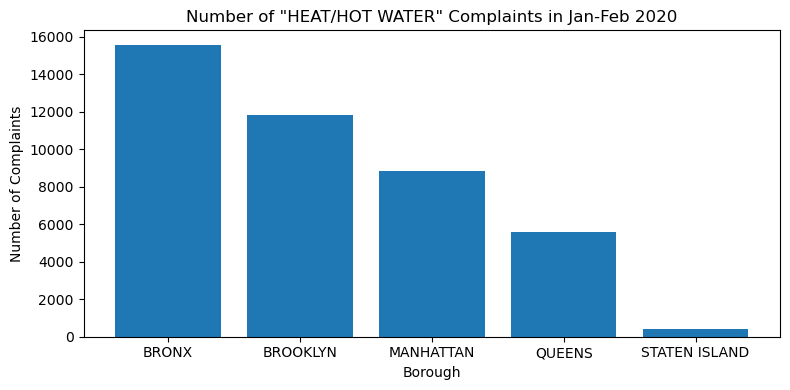

In [52]:
# Plot occurrences over Jan-Feb
top_complaint_df1 = df1[df1['complaint_type'] == top_complaint_1]
top_complaint_df1 = top_complaint_df1.groupby('borough')['count'].sum().reset_index()
top_complaint_df1 = top_complaint_df1.sort_values(by='count', ascending=False)

# Plot occurrences over Jan-Feb
plt.figure(figsize=(8, 4))
plt.bar(top_complaint_df1['borough'], top_complaint_df1['count'])
plt.xlabel('Borough')
plt.ylabel('Number of Complaints')
plt.title(f'Number of "{top_complaint_1}" Complaints in Jan-Feb 2020')
plt.tight_layout()
plt.show()

3. Find the most common complaint type for Jun-Jul 2020

In [61]:
df2 = pd.read_csv('complaints_jun_jul_2020.csv')
top_complaint_2 = df2.groupby('complaint_type')['count'].sum().idxmax()
top_complaint_2

'Noise - Residential'

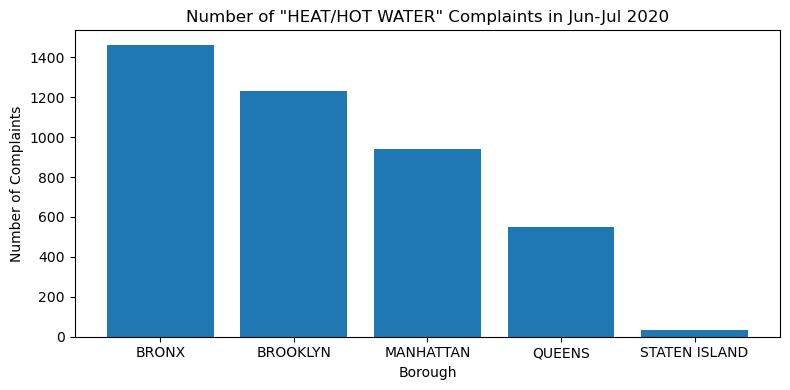

In [56]:
# Plot occurrences over Jun-Jul
top_complaint_df2 = df2[df2['complaint_type'] == top_complaint_1]
top_complaint_df2 = top_complaint_df2.groupby('borough')['count'].sum().reset_index()
top_complaint_df2 = top_complaint_df2.sort_values(by='count', ascending=False)


plt.figure(figsize=(8, 4))
plt.bar(top_complaint_df2['borough'], top_complaint_df2['count'])
plt.xlabel('Borough')
plt.ylabel('Number of Complaints')
plt.title(f'Number of "{top_complaint_1}" Complaints in Jun-Jul 2020')
plt.tight_layout()
plt.show()

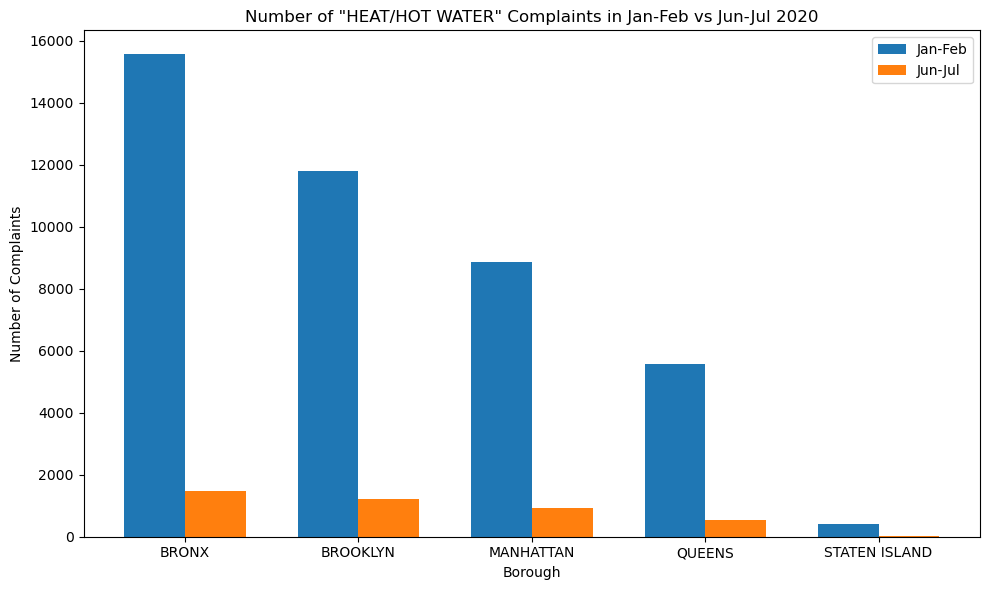

In [58]:
import numpy as np

boroughs = top_complaint_df1['borough'].unique()
x = np.arange(len(boroughs))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, top_complaint_df1['count'], width, label='Jan-Feb')
bar2 = ax.bar(x + width/2, top_complaint_df2['count'], width, label='Jun-Jul')

ax.set_xlabel('Borough')
ax.set_ylabel('Number of Complaints')
ax.set_title(f'Number of "{top_complaint_1}" Complaints in Jan-Feb vs Jun-Jul 2020')
ax.set_xticks(x)
ax.set_xticklabels(boroughs)
ax.legend()

plt.tight_layout()
plt.show()

### Task 4: Build a Bokeh Dashboard

1. Compress 2020 file from Task 1

2. Pre-process the data to generate monthly average create-to-closed times for each zipcode

In [17]:
# Pre-processing Script
import dask.dataframe as dd
import pandas as pd
import tarfile
from io import BytesIO

def preprocess_data(input_file):
    with tarfile.open(input_file, 'r:gz') as tar:
        csv_file = tar.extractfile(tar.getmembers()[0])
        csv_data = BytesIO(csv_file.read())  

    df = pd.read_csv(csv_data, header=None, usecols=[1, 2, 5, 8], 
                     names=['created_date', 'closed_date', 'complaint_type', 'incident_zip'],
                     dtype={'incident_zip': 'float64'})

    df['created_date'] = pd.to_datetime(df['created_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df['closed_date'] = pd.to_datetime(df['closed_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

    df = df.dropna(subset=['created_date', 'closed_date', 'incident_zip'])

    df = df[(df['created_date'] >= '2020-01-01') & (df['created_date'] < '2021-01-01')]

    df['incident_zip'] = df['incident_zip'].astype('int64')
    df['response_time_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600
    df = df[df['response_time_hours'] > 0]

    df['month'] = df['closed_date'].dt.to_period('M')

    ddf = dd.from_pandas(df, npartitions=4)
    result = ddf.groupby(['incident_zip', 'month'])['response_time_hours'].mean().reset_index()

    result.compute().to_csv('monthly_avg_response_times.csv', index=False)

preprocess_data('nyc_311_2020.tgz')

3. Create a Bokeh dashboard:

- Install Bokeh: `pip install bokeh`
- Write the python script for the Bokeh dashboard:

In [12]:
# save script as nyc_dashboard.py

from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import Select
from bokeh.plotting import figure
import pandas as pd


df = pd.read_csv('monthly_avg_response_times.csv', parse_dates=['month'])
df['incident_zip'] = df['incident_zip'].astype(str)

zipcode_options = sorted(df['incident_zip'].unique().tolist())

zipcode1_select = Select(title="Zipcode 1", options=zipcode_options, value="10001")
zipcode2_select = Select(title="Zipcode 2", options=zipcode_options, value="10002")

p = figure(title="Monthly Response Times", x_axis_type="datetime", height=400, width=700)
p.xaxis.axis_label = "Month"
p.yaxis.axis_label = "Response Time (Hours)"

# Ensure data is sorted by month
df = df.sort_values('month')

# Initial plot for all data
all_data = df.groupby('month')['response_time_hours'].mean().reset_index()
p.line(all_data['month'], all_data['response_time_hours'], line_width=2, color='gray', legend_label="All Data")

# Plot for the first selected zipcodes
zipcode1_data = df[df['incident_zip'] == zipcode1_select.value]
zipcode2_data = df[df['incident_zip'] == zipcode2_select.value]
line_zip1 = p.line(zipcode1_data['month'], zipcode1_data['response_time_hours'], line_width=2, color='blue', legend_label=f"Zipcode {zipcode1_select.value}")
line_zip2 = p.line(zipcode2_data['month'], zipcode2_data['response_time_hours'], line_width=2, color='green', legend_label=f"Zipcode {zipcode2_select.value}")

p.legend.location = "top_left"
p.legend.label_text_font_size = '10pt'
p.legend.orientation = "horizontal"
p.add_layout(p.legend[0], 'below')

def update_plot(attr, old, new):
    # Update data for Zipcode 1
    zipcode1_data = df[df['incident_zip'] == zipcode1_select.value]
    line_zip1.data_source.data = {'x': zipcode1_data['month'], 'y': zipcode1_data['response_time_hours']}

    # Update data for Zipcode 2
    zipcode2_data = df[df['incident_zip'] == zipcode2_select.value]
    line_zip2.data_source.data = {'x': zipcode2_data['month'], 'y': zipcode2_data['response_time_hours']}

    p.legend.items = [
        ('All Data', [p.renderers[0]]),
        (f"Zipcode {zipcode1_select.value}", [line_zip1]),
        (f"Zipcode {zipcode2_select.value}", [line_zip2])
    ]

# Attach the update function to the dropdowns
zipcode1_select.on_change('value', update_plot)
zipcode2_select.on_change('value', update_plot)

# Define the layout and attach it to the document
layout = column(zipcode1_select, zipcode2_select, p)
curdoc().add_root(layout)
curdoc().title = "NYC 311 Dashboard"

3. Run the Bokeh dashboard:

bokeh serve --show nyc_dashboard.py --port 8080

4. Commit your Bokeh code: